# DEA and marker identification for cross-disease monocyte-derived macrophage analysis:

import modules:

In [1]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
%load_ext lab_black

set paths:

In [3]:
path_adata_mdm = (
    "../../data/HLCA_extended/extension_disease/scarches_emb_MdM_full-matrix.h5ad"
)
dir_figures = "../../results/figures/"
dir_differential_expr_analysis = "../../results/DEAs/MDM_clusters/"

load data:

In [4]:
adata_mdm = sc.read_h5ad(path_adata_mdm)

set figure parameters:

In [5]:
sc.set_figure_params(figsize=(4, 4))

create empty dict for figures:

In [6]:
FIGURES = dict()

## Differential gene expression analysis:

Print number of cells per cluster (has to be included in the manuscript as we do statistical tests on the clusters)

In [7]:
adata_mdm.obs["leiden_0.3"].value_counts()

0    64915
1    47539
2    32027
3    31097
4    25267
5     1998
6      307
Name: leiden_0.3, dtype: int64

Reduce genes: filter out genes expressed in few cells or genes expressed in a single dataset.

Filtering based on number of cells that express the gene:

In [8]:
adata_mdm.shape

(203150, 59574)

In [9]:
sc.pp.filter_genes(adata_mdm, min_cells=20)

In [10]:
adata_mdm.shape

(203150, 32369)

filter out dataset-specific genes, using groupby:

In [11]:
adata_mdm_genedf = pd.DataFrame(
    adata_mdm.X.toarray(), index=adata_mdm.obs.index, columns=adata_mdm.var.index
)

In [12]:
genes = adata_mdm_genedf.columns

In [13]:
adata_mdm_genedf["study"] = adata_mdm.obs["study"]

In [14]:
genedf_study = adata_mdm_genedf.groupby("study").agg({gene: "sum" for gene in genes})

In [15]:
gene_in_multiple_studies = (genedf_study > 0).sum(axis=0) > 1
gene_in_multiple_studies = gene_in_multiple_studies.loc[
    gene_in_multiple_studies.values
].index.tolist()

In [16]:
len(gene_in_multiple_studies)

27808

Now filter the adata object:

In [17]:
adata_mdm_filt = adata_mdm[:, gene_in_multiple_studies].copy()

Set uns['log1p'] to prevent scanpy bug in the differential expression analysis:

In [18]:
adata_mdm_filt.uns["log1p"]["base"] = None

Now perform differential expression analysis per cluster:

In [19]:
sc.tl.rank_genes_groups(adata_mdm_filt, groupby="leiden_0.3", method="wilcoxon")

And filter, such that we exclude genes highly expressed in out-group clusters, and genes lowly expressed in in-group cluster:m

In [20]:
sc.tl.filter_rank_genes_groups(
    adata_mdm_filt,
    key="rank_genes_groups",
    key_added="rank_genes_groups_filtered",
    min_in_group_fraction=0.3,
    max_out_group_fraction=0.2,
)

Store results in dictionary (all differentially expressed genes that passed filtering, and the top 15 in a separate dictionary)

In [21]:
# extract degs per cluster:
degs_per_cluster = dict()
degs_top15_per_cluster = dict()
for cluster in range(0, 7):
    degs_per_cluster[cluster] = sc.get.rank_genes_groups_df(
        adata_mdm_filt,
        group=str(cluster),
        pval_cutoff=0.05,
        # log2fc_max=,
        key="rank_genes_groups_filtered",
    ).dropna(axis=0, how="any")
    n_genes_total = degs_per_cluster[cluster].shape[0]
    degs_top15_per_cluster[str(cluster)] = (
        degs_per_cluster[cluster].names[: min(15, n_genes_total)].tolist()
    )
    print(f"Cluster {cluster}: n genes={n_genes_total}.")

Cluster 0: n genes=58.
Cluster 1: n genes=147.
Cluster 2: n genes=47.
Cluster 3: n genes=26.
Cluster 4: n genes=34.
Cluster 5: n genes=52.
Cluster 6: n genes=10.


In [22]:
# sc.tl.filter_rank_genes_groups(
#     adata_mdm_filt,
#     key="rank_genes_groups",
#     key_added="rank_genes_groups_filtered_strict",
#     min_in_group_fraction=0.5,
#     max_out_group_fraction=0.3,
# )

## Figures:

Generate a variable that includes information about both cluster and study. To prevent overcrowding of plots later on, and noise due to sparsity in low-abundance groups, set all groups (cluster + study) that have fewer than 200 cells to "Other" for each cluster:

In [23]:
adata_mdm_filt.obs["leiden_0.3_study"] = [
    f"{cl} ({st})"
    for cl, st in zip(adata_mdm_filt.obs["leiden_0.3"], adata_mdm_filt.obs.study)
]
leid_st_value_counts = adata_mdm_filt.obs["leiden_0.3_study"].value_counts()
lei_st_mapping = {gr: gr for gr in adata_mdm_filt.obs["leiden_0.3_study"].unique()}
min_n_cells = 200
for gr in leid_st_value_counts.loc[leid_st_value_counts < min_n_cells].index:
    lei_st_mapping[gr] = f"{gr[:1]} (Other)"
adata_mdm_filt.obs["leiden_0.3_study"] = adata_mdm_filt.obs["leiden_0.3_study"].map(
    lei_st_mapping
)

In [24]:
# study2color = {
#     st: col
#     for st, col in zip(
#         adata_mdm.obs.study.cat.categories, adata_mdm.uns["study_colors"]
#     )
# }

Plot general monocyte and macrophage subtype markers, to see if these are really MDMs:

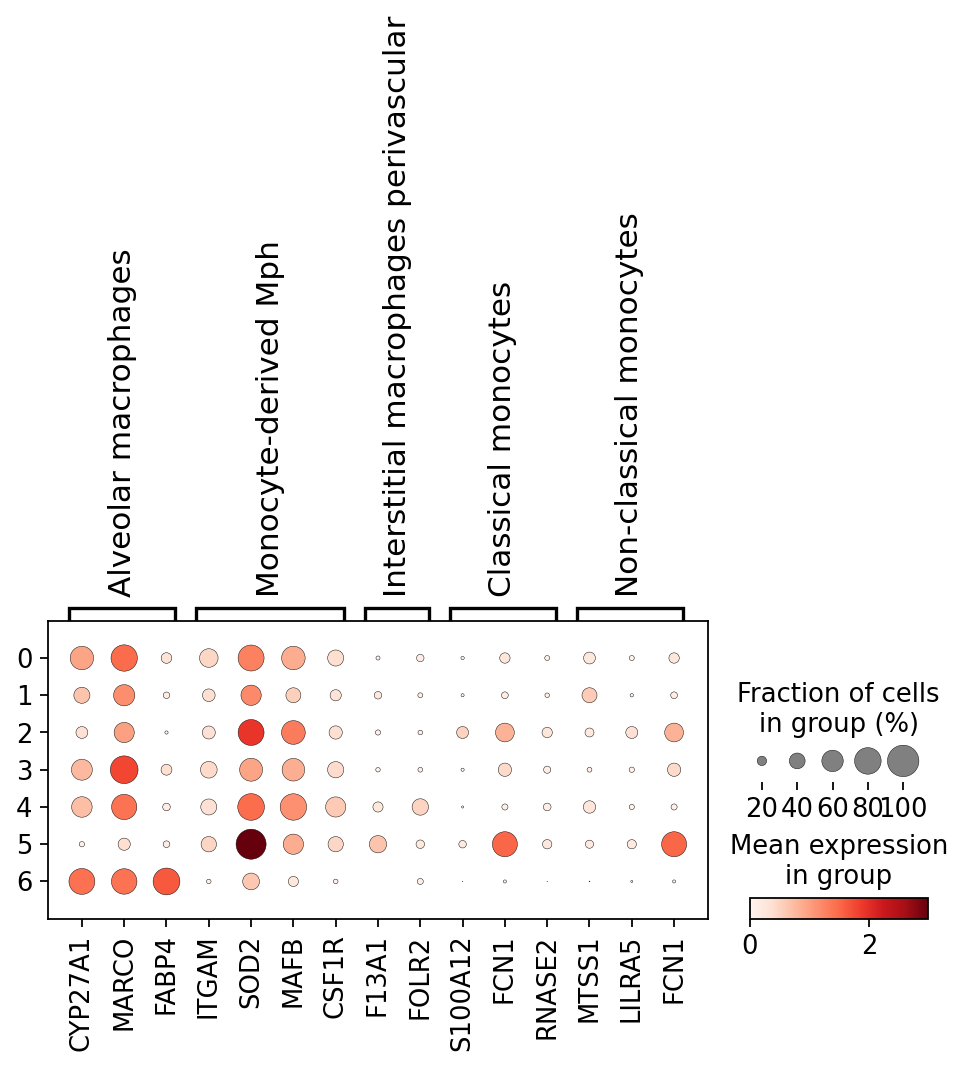

In [25]:
sc.pl.dotplot(
    adata_mdm,
    var_names={
        "Alveolar macrophages": ["CYP27A1", "MARCO", "FABP4"],
        "Monocyte-derived Mph": ["ITGAM", "SOD2", "MAFB", "CSF1R"],
        "Interstitial macrophages perivascular": ["F13A1", "FOLR2"],
        "Classical monocytes": ["S100A12", "FCN1", "RNASE2"],
        "Non-classical monocytes": ["MTSS1", "LILRA5", "FCN1"],
    },
    groupby="leiden_0.3",
)

Plot results of DEA:

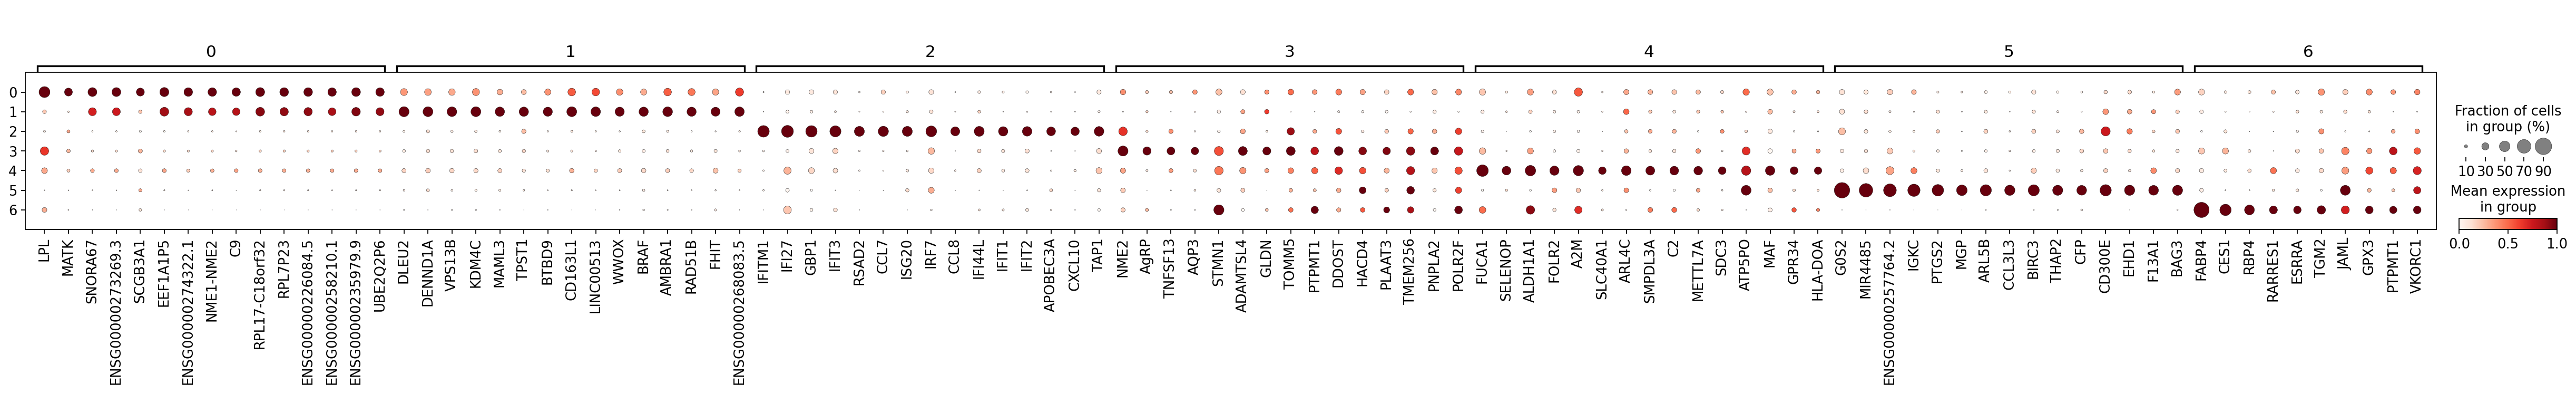

In [26]:
sc.pl.dotplot(
    adata_mdm_filt,
    groupby="leiden_0.3",
    var_names=degs_top15_per_cluster,
    dendrogram=False,
    standard_scale="var",
)

And with clusters split by study:

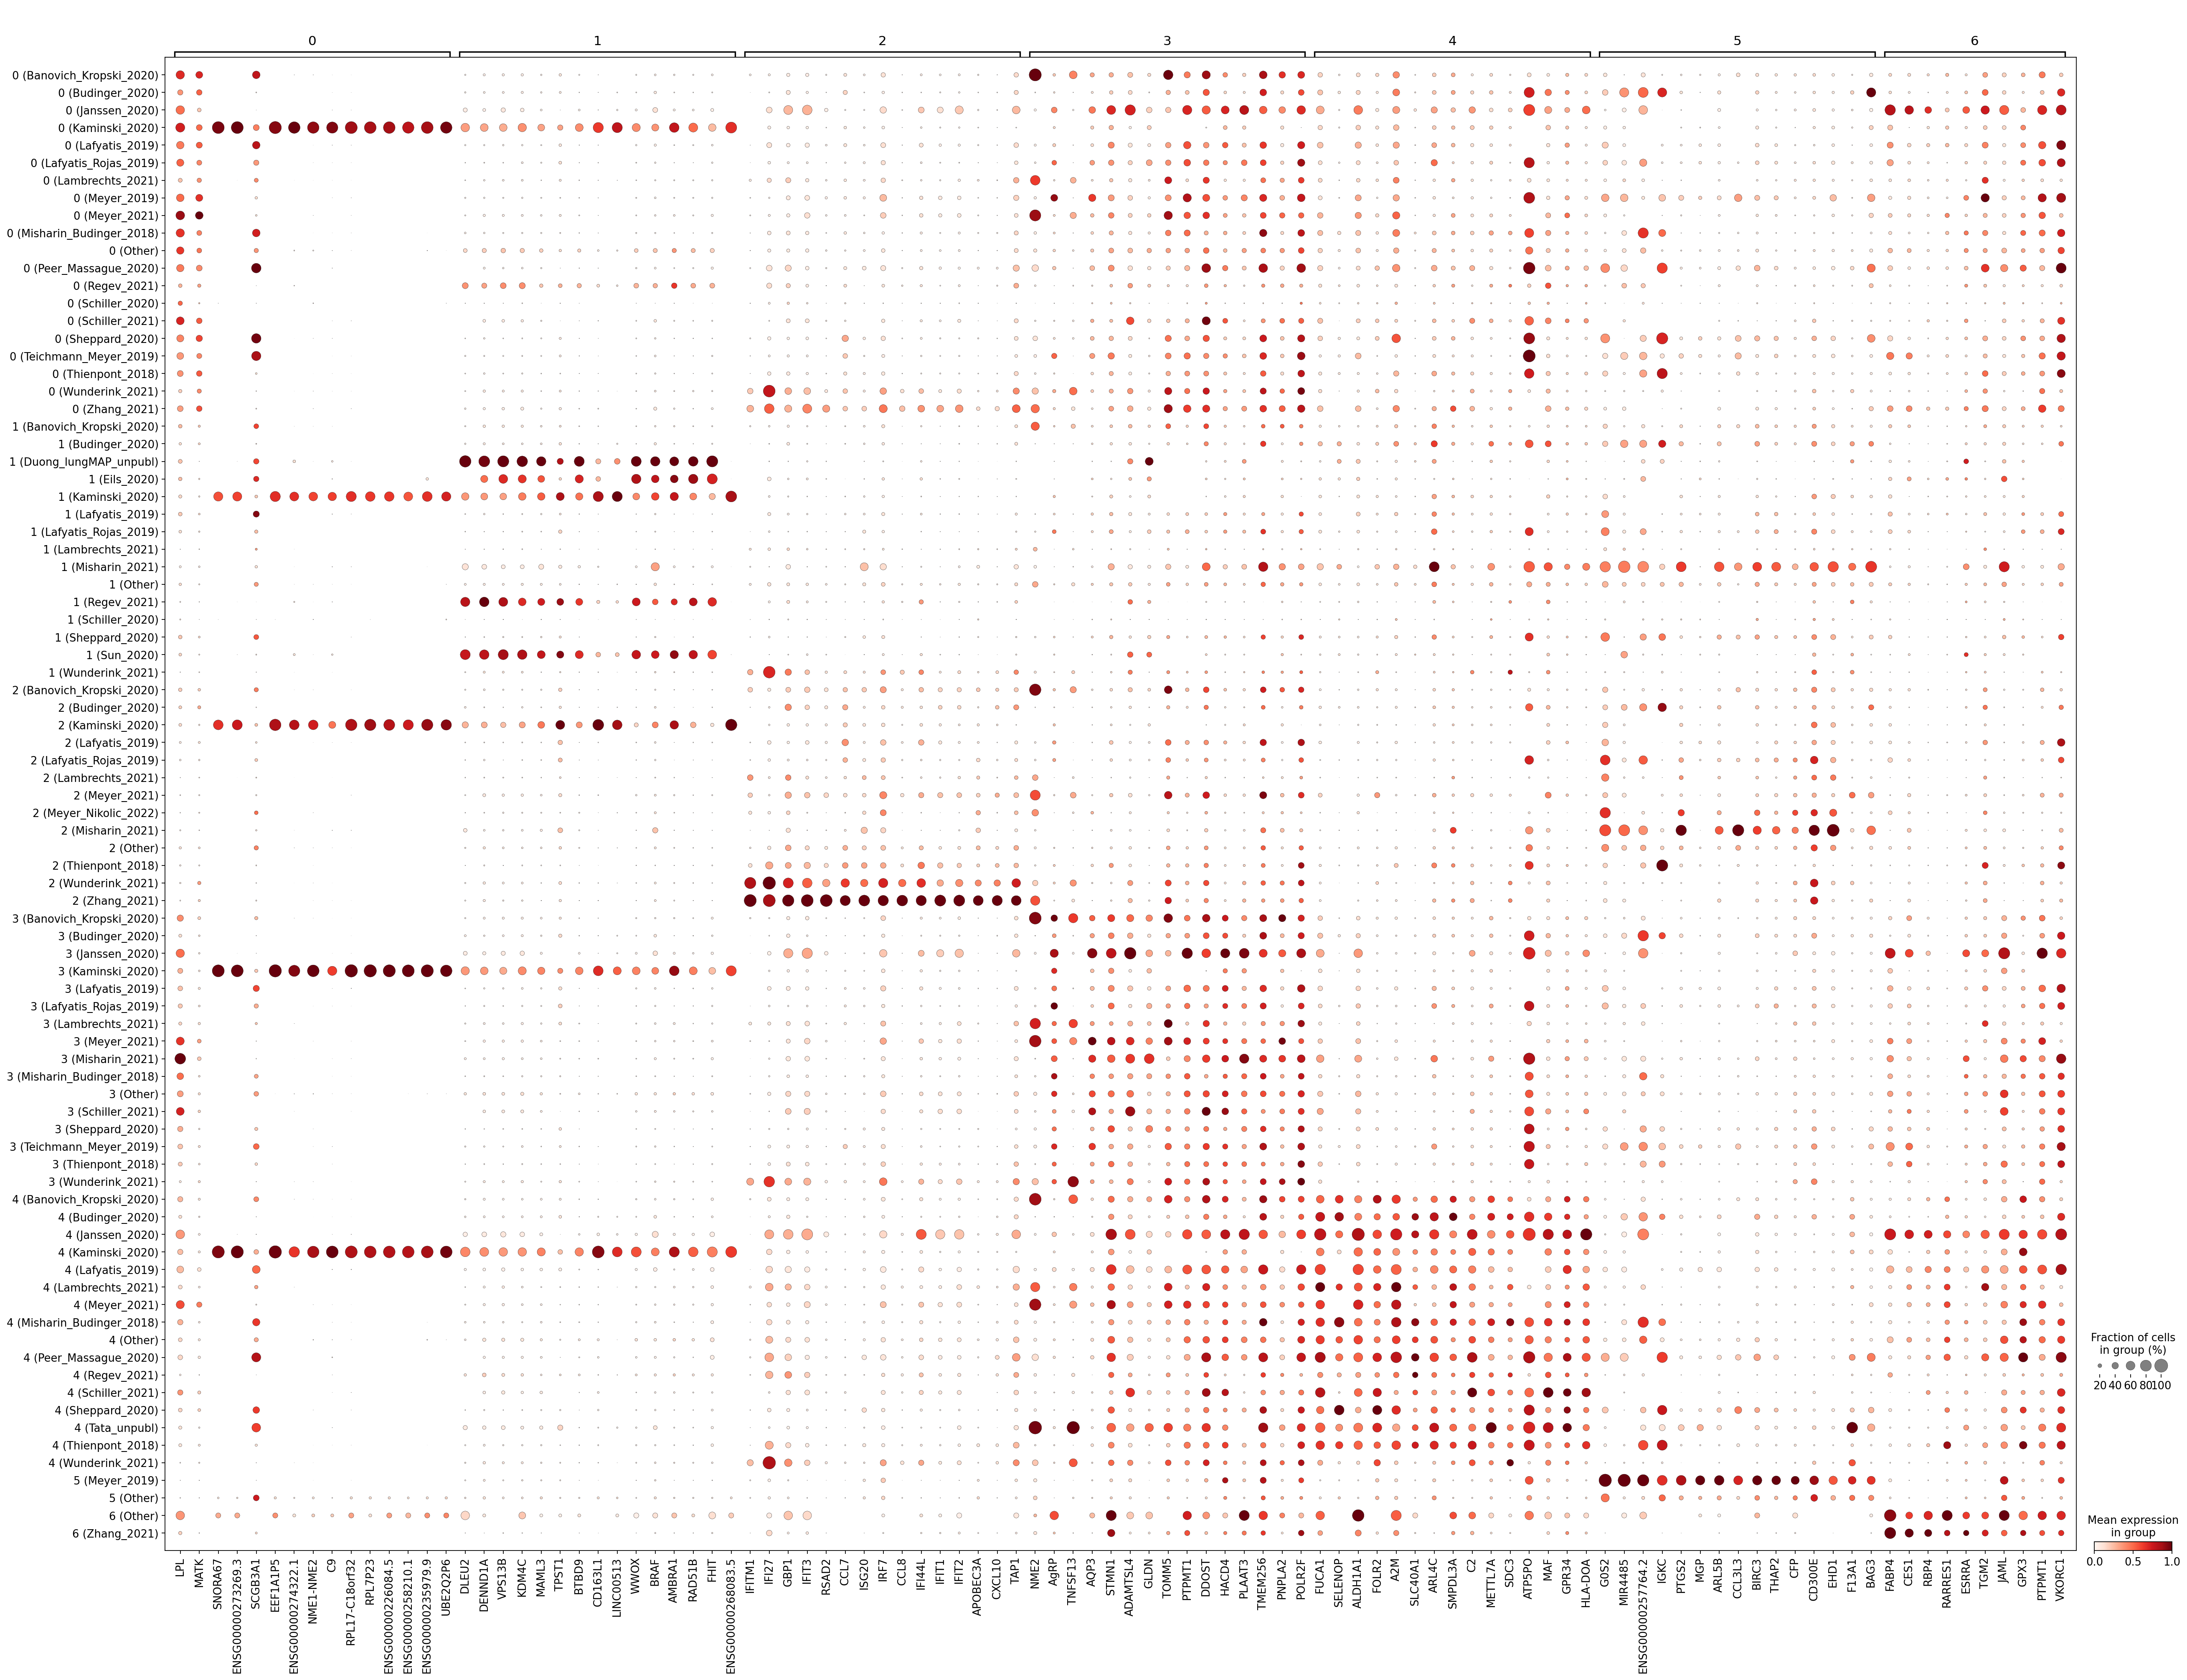

In [27]:
sc.pl.dotplot(
    adata_mdm_filt,
    groupby="leiden_0.3_study",
    var_names=degs_top15_per_cluster,
    dendrogram=False,
    standard_scale="var",
)

Notice that cluster 1 only has marker genes that are specific for single-nucleus + Kaminski data. As Kaminski was frozen tissue, it is possible that these samples also largely sampled nuclei. To check the proportion of single nucleus + Kaminski in this cluster, let's plot the following:

In [28]:
adata_mdm.obs["cells_or_nuclei_kaminski"] = [
    cvn if st != "Kaminski_2020" else f"{cvn} (Kaminski)"
    for cvn, st in zip(adata_mdm.obs.cells_or_nuclei, adata_mdm.obs.study)
]

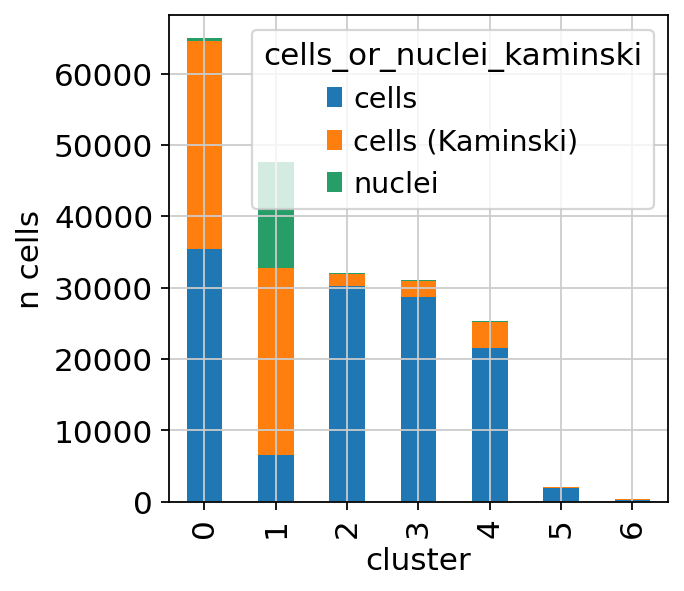

In [29]:
pd.crosstab(
    adata_mdm.obs["leiden_0.3"], adata_mdm.obs["cells_or_nuclei_kaminski"]
).plot(kind="bar", stacked=True)
plt.ylabel("n cells")
plt.xlabel("cluster")
plt.show()

For each cluster, calculate the proportion of cells coming from the most "abundant" subject:

In [30]:
cl_subj_props = pd.crosstab(adata_mdm.obs["leiden_0.3"], adata_mdm.obs["subject_ID"])
cl_subj_props = cl_subj_props.divide(cl_subj_props.sum(axis=1), axis=0) * 100

In [31]:
for cl in cl_subj_props.index:
    print(
        f"Cluster {cl}, highest subject propostion:",
        round(cl_subj_props.loc[cl, :].sort_values(ascending=False)[0], 1),
    )

Cluster 0, highest subject propostion: 4.8
Cluster 1, highest subject propostion: 8.1
Cluster 2, highest subject propostion: 15.2
Cluster 3, highest subject propostion: 7.8
Cluster 4, highest subject propostion: 28.8
Cluster 5, highest subject propostion: 71.5
Cluster 6, highest subject propostion: 85.7


Based on markers and correspondence with previously published work, we name the clusters as follows:

In [32]:
cluster_naming = {
    "0": "profibrotic SPP1 high (0)",
    "1": "MdMs (1)",
    "2": "inflammatory CCL2 high (2)",
    "3": "MARCO high (3)",
    "4": "inflammatory C1QA high (4)",
    "5": "early (single subject) (5)",
    "6": "alveolar mph (single subject) (6)",
}
adata_mdm_filt.obs["leiden_named"] = adata_mdm.obs["leiden_0.3"].map(cluster_naming)

/home/icb/lisa.sikkema/miniconda3/envs/HLCA_basic/lib/python3.7/site-packages/ipykernel_launcher.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  # Remove the CWD from sys.path while we load stuff.


Selection of final markers, excluding single-subject cluster 5 and 6. Also note that we add general MDM markers, and no extra markers for cluster 1, as this cluster did not show consistent and unique marker expression across studies.

In [33]:
final_markers_all = {
    "MdMs": ["ITGAM", "SOD2", "MAFB", "CSF1R"],
    cluster_naming["2"]: [  # MoAM2
        "CCL2",
        "IL1RN",
        "C15orf48",
        "S100A12",
    ],  # MoAM2
    cluster_naming["4"]: [
        "CCL18",
        "C1QA",
        "TREM2",
        "PLTP",
        "CD4",
        "IL18",
        "TMEM176A",
        "AKR1B1",
    ],  # MoAM3
    cluster_naming["3"]: ["FBP1", "MCEMP1", "MARCO"],  # MoAM4
    cluster_naming["0"]: [
        "SPP1",
        # "PLA2G7",
        "MMP9",
        "CHI3L1",
        "CHIT1",
        "LPL",
        "FDX1",
    ],  # MoAM1?
    # nothing cluster 1 specific, MoAM4?
    # cluster_naming["5"]: [
    #     "IL1B",
    #     "CXCL8",
    #     "G0S2",
    #     "FCN1",
    # ],  # MoAM1
    # cluster_naming["6"]: ["FABP4"],  # tissue-resident macrophages
}

Order categories based on early to late MDM stage (with 6 and 1 added at the end):

In [34]:
adata_mdm_filt.obs.leiden_named = (
    adata_mdm_filt.obs.leiden_named.cat.reorder_categories(
        [
            cluster_naming["5"],
            cluster_naming["2"],
            cluster_naming["4"],
            cluster_naming["3"],
            cluster_naming["0"],
            cluster_naming["6"],
            cluster_naming["1"],
        ]
    )
)

Remove cluster 5 and 6 for plots:

In [35]:
adata_mdm_no5_and_6 = adata_mdm_filt[
    adata_mdm_filt.obs["leiden_0.3"].isin(["0", "1", "2", "3", "4"]), :
].copy()

Plot final markers:

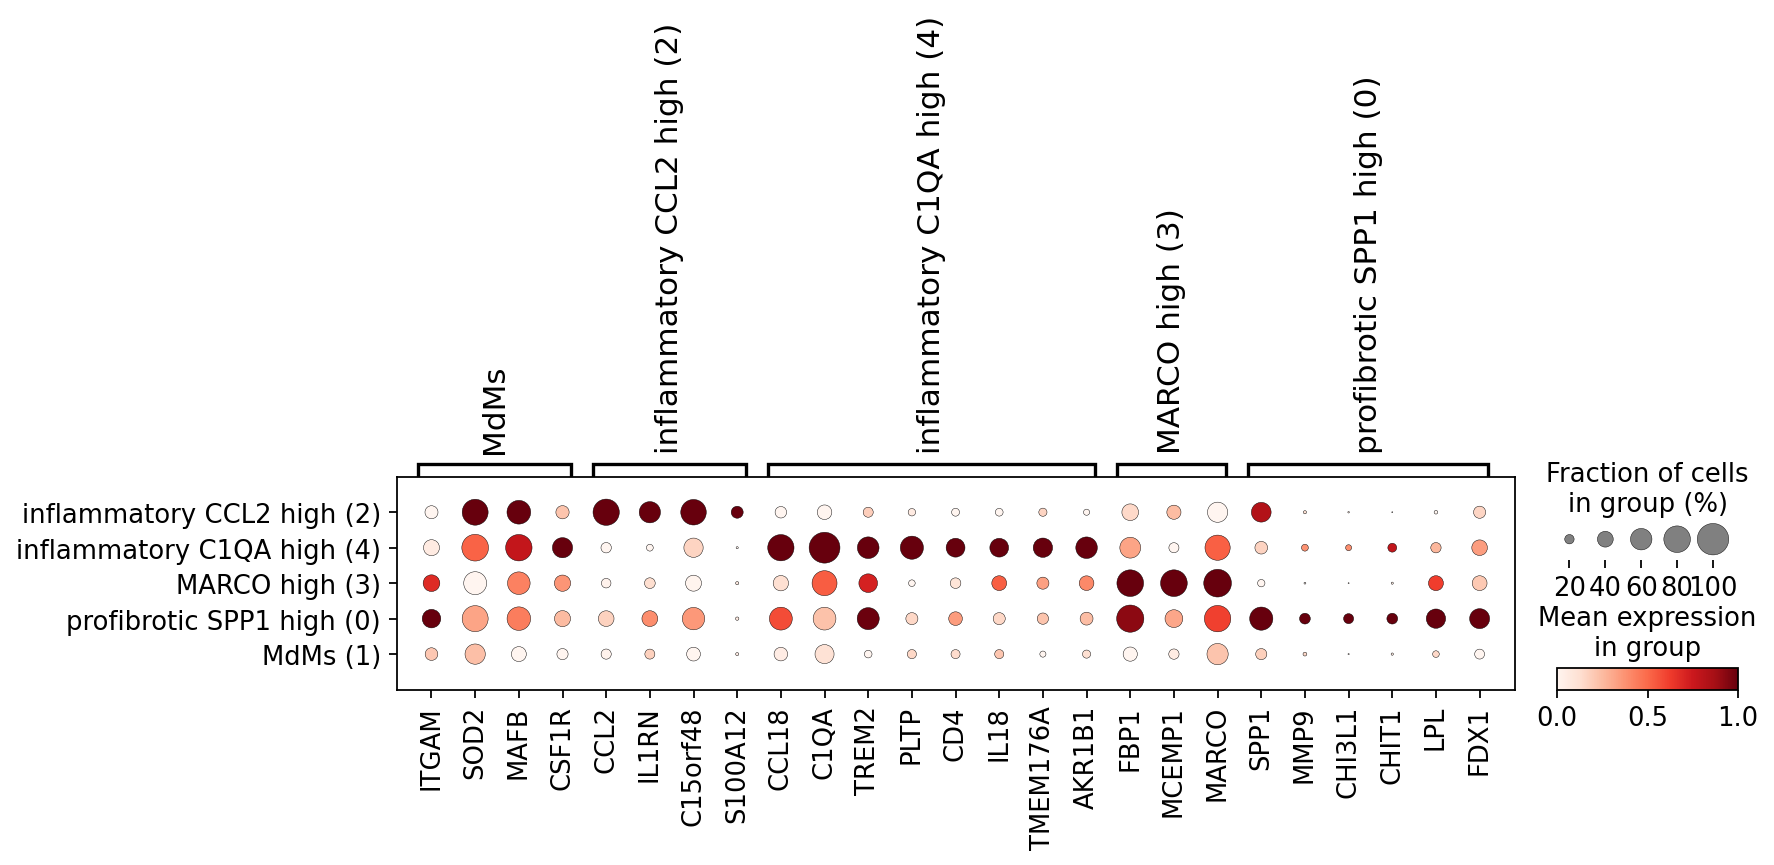

In [36]:
FIGURES["7_MdM_markers"] = sc.pl.dotplot(
    adata_mdm_no5_and_6,
    var_names=final_markers_all,
    groupby="leiden_named",
    standard_scale="var",
    return_fig=True,
)
FIGURES["7_MdM_markers"].show()

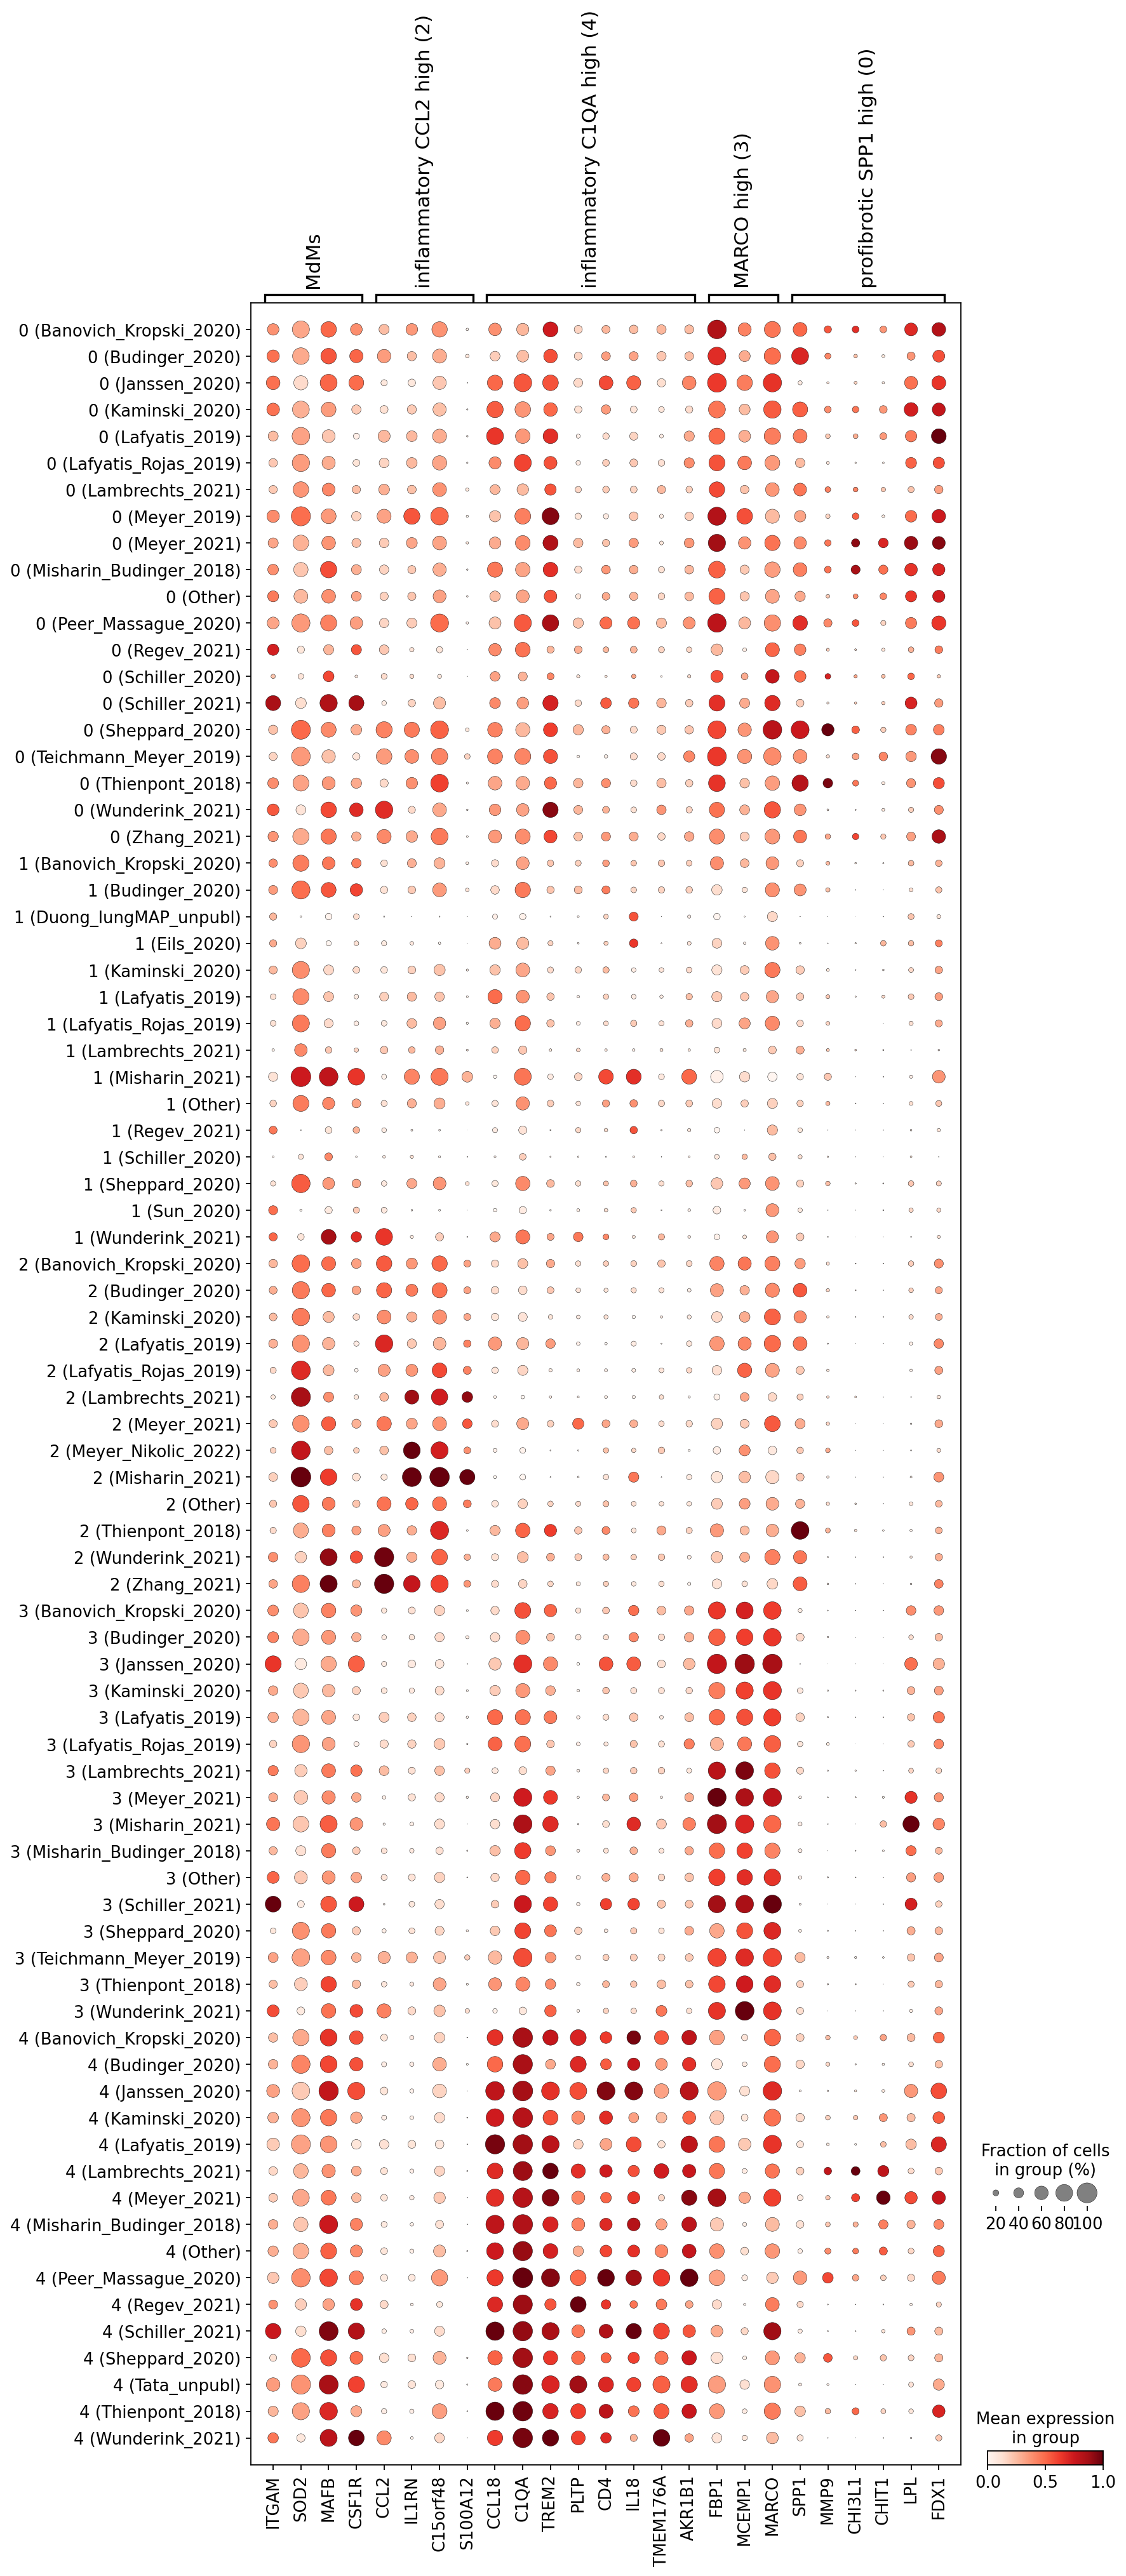

In [37]:
FIGURES["23_MdM_markers_per_study"] = sc.pl.dotplot(
    adata_mdm_no5_and_6,
    var_names=final_markers_all,
    groupby="leiden_0.3_study",
    standard_scale="var",
    return_fig=True,
)
FIGURES["23_MdM_markers_per_study"].show()

## Store results:

Store filtered differentially expressed genes per cluster:

In [38]:
for cluster in range(0, 7):
    deg_df = degs_per_cluster[cluster].set_index("names")
    deg_df.to_csv(
        os.path.join(
            dir_differential_expr_analysis, f"DEGs_MDM_cluster_{cluster}_filtered.csv"
        )
    )

Store figures:

In [39]:
for figname, fig in FIGURES.items():
    print("Storing", figname)
    fig.savefig(
        os.path.join(dir_figures, f"{figname}.png"),
        bbox_inches="tight",
        dpi=140,
        transparent=True,
    )
    plt.close()

Storing 7_MdM_markers
Storing 23_MdM_markers_per_study
